# Implement probabilistic scores for ensemble forecasts
 
Now let's implement the ensemble scores. Please refer to the Dropbox document for their definition. 

1. Spread/Skill ratio: As mentioned in Scher and Messori (2020) there is a right way to do the order of the computations. Read their paragraph on it.
2. CRPS: Try the `properscoring` package. This one should be good.
3. Rank histogram: Try the `rankhistogram` package. No idea if this one is good. If it's ok but requires minor changes, we can consider a pull request. Otherwise, let's just write our own implementation. 

For all three scores:
- Use `xarray` as much as possible. Write a function similar to `src.score.compute_weighted_rmse.py`. 
- Ignore the weighted part at first.
- Create simple synthetic datasets to test extreme cases. E.g. `ensemble = [1, 1, 1]`, `obs=[1]` should result in a CRPS of 0. Think about what good sanity checks are for each score. For the rank histogram, for example, try to build examples that should end up in the shapes from the Dropbox document (overdispersion, underdispersion, etc.)
- Test the three functions with the "real" data from the dropout ensemble.
- Now the weighted part: Because the area of each lat-lon square is not the same but in fact varies with cos(lat), we want to weigh each grid point proportional to its area. This is already implemented for the rmse and acc scores in `src/score.py`. Implement this for the three probabilistic scores and compare to the unweighted scores. They shouldn't be too different. Implementing this for the rank histogram might require some thinking. We can talk about this together.

ToDo:
1. use command-line script to get prediction dataset
2. shifting code to, working with full data on remote PC
3. CRPS averaging. sanity checks.  re-writing rank histogram.
4. creating function to compare different models on CRPS, Spread-skill, RankHistogram. should be simple.

In [1]:
%load_ext autoreload
%autoreload 2

In [271]:
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
import matplotlib.pyplot as plt

In [3]:
tf.__version__

'1.14.0'

In [4]:
datadir = '/Users/sagar/Library/Mobile\ Documents/com~apple~CloudDocs/studies/WeatherBench/Testing_WeatherBench/test/'# Change this to where you downloaded the data

In [6]:
!ls $datadir

13-mean.nc                     geopotential
13-resnet_bn_dr_0.1.h5         temperature
13-resnet_bn_dr_0.1_weights.h5 u_component_of_wind
13-std.nc                      v_component_of_wind
constants


In [5]:
exp_id = '13-resnet_bn_dr_0.1'
var_dict = {'geopotential': ('z', [200, 500, 850]), 'temperature': ('t', [200, 500, 850]), 
            'u_component_of_wind': ('u', [200, 500, 850]), 'v_component_of_wind': ('v', [200, 500, 850]), 
            'constants': ['lsm','orography','lat2d']}  
#our input data has 'levels'. is that geopotential height?  
#why just 3 constants, not 5
output_vars = ['z_500', 't_850']
filters = [128, 128, 128, 128, 128, 128, 128, 128, 2]
kernels = [7, 3, 3, 3, 3, 3, 3, 3, 3]
lead_time = 72 #prediction of forecast is at 72 hours after input time.
lr = 0.5e-4
early_stopping_patience = 10
reduce_lr_patience = 5
data_subsample = 2
norm_subsample = 30000
bn_position = 'post'
use_bias = 1
dropout = 0.1  # This is the important one

batch_size = 32
nt_in = 1
l2 = 0
skip = True

In [7]:
#ds = xr.merge([xr.open_mfdataset('../test/{var}/*.nc', combine='by_coords') for var in var_dict.keys()]) 
df1=xr.open_mfdataset('../test/geopotential/*.nc', combine='by_coords') 
df2=xr.open_mfdataset('../test/temperature/*.nc', combine='by_coords') 
df3=xr.open_mfdataset('../test/u_component_of_wind/*.nc', combine='by_coords') 
df4=xr.open_mfdataset('../test/v_component_of_wind/*.nc', combine='by_coords')  
df5=xr.open_mfdataset('../test/constants/*.nc', combine='by_coords')  
ds=xr.merge([df1,df2,df3,df4,df5])

In [8]:
mean = xr.open_dataarray('../test/13-mean.nc') #for just our subsampled data. 15 levels ('the constants are at level=1)':z200,z500,z850,t200 and so on.
std = xr.open_dataarray('../test/13-std.nc')

In [9]:
dg_test = DataGenerator(
    ds, var_dict, lead_time, batch_size=batch_size, mean=mean, std=std,
    shuffle=False, output_vars=output_vars
)

DG start 18:31:15.231140
DG normalize 18:31:15.257698
DG load 18:31:15.270257
Loading data into RAM
DG done 18:31:46.228804


In [10]:
# You can index into the data generator to obain a feature/target pair
# [batch, x, y, channel]
X, y = dg_test[0]
X.shape, y.shape

((32, 32, 64, 15), (32, 32, 64, 2))

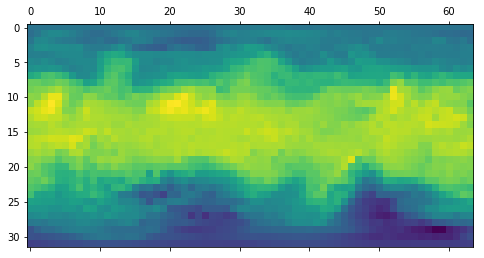

In [11]:
plt.matshow(y[0, :, :, 1]) #y[...,0] is z500 and y[...,1] is t850. normalized. 
#y is the observation after lead_time (=72) hours from input X. The ground truth.

# Load the model
Now let's load the pretrained model. Check the build resnet option .

In [12]:
model = build_resnet(
    filters, kernels, input_shape=(
        len(dg_test.data.lat), len(dg_test.data.lon), len(dg_test.data.level) * nt_in
    ),
    bn_position=bn_position, use_bias=use_bias, l2=l2, skip=skip,
    dropout=dropout
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
model.compile('adam', 'mse')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 15)] 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  94208       input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         activation[0][0]                 
______________________________________________________________________________________________

In [14]:
model.load_weights('../test/13-resnet_bn_dr_0.1_weights.h5')

## Create a deterministic prediction

The model has been trained to create a deterministic prediction. For this dropout is turned off during test time. Let's create a prediction for the first sample. Thanks to Tensorflow 2 we can tread the model as a function just like in PyTorch.

In [15]:
#pred = model(X[:1]).numpy().squeeze(); pred.shape; #to add tf.enable_eager_execution() in src/networks.py line6. have to remove if you want to run ensemble prediction :(.

In [16]:
# Look at the predictions
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# ax1.matshow(pred[..., 0]) #z500 normalized
# ax2.matshow(pred[..., 1]) #t850 normalized

# Create an ensemble using test-time dropout
Now it's your turn. The pretrained model contains several dropout layers which are only active during training. Your job is to turn dropout on during inference as well. This should result in a model that creates a slightly different prediction every time. Hint: Google "Keras test-time dropout".

In [17]:
##weirdly this function works when tf.enable_eager_execution() is disabled.
#but 'pred' for single determinstic works when tf.enable_eager_execution() is enabled. 
#issue with tensorflow version. couldn't solve right now.

#keras switches off test time dropout by default. we could either switch it on permanently.. by putting somewhere an argument training=true). this will put both training and testing to use dropout
#but since we have a pre trained model, better just to activate dropout in testing rather than training again. beware: we also activate bacthnorm or any other that was inactive in test phase by default.
#https://stackoverflow.com/questions/52756283/adding-dropout-to-testing-inference-phase
from tensorflow.keras import backend as K
func = K.function(model.inputs + [K.learning_phase()], model.outputs)

In [18]:
# to use dropout in testing phase, pass 1 to set the learning phase to training mode
outputs = func([X[:1]] + [1.]) #for a single sample. #gives a new prediction each time.
pred2 = np.asarray(outputs, dtype=np.float32).squeeze(); print(pred2.shape) #reshape
#outputs

(32, 64, 2)


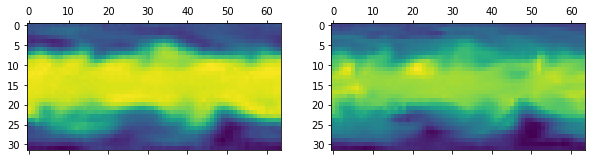

In [19]:
# Look at the predictions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.matshow(pred2[..., 0]) #z500 normalized
ax2.matshow(pred2[..., 1]) #t850 normalized

# Creating Ensemble Forecasts
 I Inputs. N forecasts per input.

In [223]:
input_number=32 #keep it lower for testing. takes time.
#Different input times each for which an ensemble of predictions is made. 
#Ques: limited to batch size 32???
number_of_forecasts=100
# pred_ensemble=np.ndarray(shape=(input_number,number_of_forecasts,32,64,2),dtype=np.float32)
# for i in range(input_number):
#     for f in range(number_of_forecasts):
#         outputs = func([X[i:i+1]] + [1.]) #new prediction each time for same sample.
#         pred1 = np.asarray(outputs, dtype=np.float32).squeeze()
#         pred_ensemble[i,f,...] = pred1 

#concise version
pred_ensemble = np.array([np.asarray(func([X[:input_number]] + [1.]), dtype=np.float32).squeeze() for _ in range(number_of_forecasts)])


In [224]:
print(pred_ensemble.shape) #(forecast, input, lat, lon, variable)

(100, 32, 32, 64, 2)


In [225]:
y[:input_number].shape #ground truth. Is this correct?

(32, 32, 64, 2)

In [226]:
#convert to xarray dataset
preds = xr.Dataset({
    'z500': xr.DataArray(pred_ensemble[...,0],
        dims=['forecast_number', 'input_number','lat', 'lon'],
        coords={'forecast_number': np.arange(number_of_forecasts),'input_number': np.arange(input_number), 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,},)
    ,
    't850': xr.DataArray(pred_ensemble[...,1],
        dims=['forecast_number', 'input_number','lat', 'lon'],
        coords={'forecast_number': np.arange(number_of_forecasts),'input_number': np.arange(input_number), 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,},)
})

observation= xr.Dataset({
    'z500': xr.DataArray(y[:input_number,:,:,0],
                         dims=['input_number','lat','lon'],
                         coords={'input_number':np.arange(input_number),'lat':dg_test.data.lat,'lon':dg_test.data.lon},)
    ,
    't850': xr.DataArray(y[:input_number,:,:,1],dims=['input_number','lat','lon'],coords={'input_number':np.arange(input_number),'lat':dg_test.data.lat,'lon':dg_test.data.lon},)          
})

In [227]:
#preds

<xarray.Dataset>
Dimensions:          (forecast_number: 100, input_number: 32, lat: 32, lon: 64)
Coordinates:
  * forecast_number  (forecast_number) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * input_number     (input_number) int64 0 1 2 3 4 5 6 ... 25 26 27 28 29 30 31
  * lat              (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * lon              (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
Data variables:
    z500             (forecast_number, input_number, lat, lon) float32 -0.8921148 ... -1.640721
    t850             (forecast_number, input_number, lat, lon) float32 -1.1058306 ... -1.7279617

# Evaluation methods: Spread-skill, CRPS, Rank histogram
check src/score.py.

In [228]:
#Method 1: Evaluating Spread-Skill Ratio (Based on Paper by scher and Messori 2020: Ensemble NN forecasts with SVD)
mean_spread=compute_weighted_meanspread(preds); print(mean_spread)
mean_rmse=compute_weighted_meanrmse(observation,preds); print(mean_rmse)

spread_skill_ratio_z500=mean_spread.z500_mean_spread/mean_rmse.z500_mean_rmse
spread_skill_ratio_t850=mean_spread.t850_mean_spread/mean_rmse.t850_mean_rmse
print(spread_skill_ratio_z500)
print(spread_skill_ratio_t850) #CouldDo: make a single Dataset by keeping same name as z500, t850

<xarray.Dataset>
Dimensions:           ()
Data variables:
    z500_mean_spread  float32 0.2161823
    t850_mean_spread  float32 0.21091646
<xarray.Dataset>
Dimensions:         ()
Data variables:
    z500_mean_rmse  float32 0.15734786
    t850_mean_rmse  float32 0.15593107
<xarray.DataArray ()>
array(1.3739133, dtype=float32)
<xarray.DataArray ()>
array(1.3526262, dtype=float32)


In [269]:
#this implementation is with weighted latitude. the above one is not.
mean_spread=compute_weighted_meanspread(preds); print(mean_spread)
mean_rmse=compute_weighted_meanrmse(observation,preds); print(mean_rmse)

spread_skill_ratio_z500=mean_spread.z500_mean_spread/mean_rmse.z500_mean_rmse
spread_skill_ratio_t850=mean_spread.t850_mean_spread/mean_rmse.t850_mean_rmse
print(spread_skill_ratio_z500)
print(spread_skill_ratio_t850) #CouldDo: make a single Dataset by keeping same name as z500, t850

<xarray.Dataset>
Dimensions:           ()
Data variables:
    z500_mean_spread  float64 0.1979
    t850_mean_spread  float64 0.1997
<xarray.Dataset>
Dimensions:         ()
Data variables:
    z500_mean_rmse  float64 0.1269
    t850_mean_rmse  float64 0.1425
<xarray.DataArray ()>
array(1.55995965)
<xarray.DataArray ()>
array(1.40177969)


In [270]:
#Method 2: Continuous Ranked Probablity Score
#!pip install properscoring
crps_score=crps_score(observation, preds,1); print(crps_score)
#ToDo: solve this error. if i re-run cell block 2 (from src.score import *), then it runs fine. See next cell block. possibly becasue  change datatype by calling to_array() function)

TypeError: 'Dataset' object is not callable

In [272]:
#Method 2: Continuous Ranked Probablity Score
#!pip install properscoring
crps_score=crps_score(observation, preds,1); print(crps_score)

<xarray.Dataset>
Dimensions:       (input_number: 32, lat: 32, lon: 64)
Coordinates:
  * input_number  (input_number) int64 0 1 2 3 4 5 6 7 ... 25 26 27 28 29 30 31
  * lat           (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * lon           (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
Data variables:
    z500          (input_number, lat, lon) float64 0.1195 0.09359 ... 0.2569
    t850          (input_number, lat, lon) float64 0.2959 0.3 ... 0.07194


In [273]:
#Question: How to average? 
#ToDo: once resolved. add to src/score.py
#way 1
crps=crps_score.mean(); print(crps)

#way 2: weighted
weights_lat = np.cos(np.deg2rad(crps_score.lat))
weights_lat /= weights_lat.mean()
var1 = (crps_score* weights_lat).mean(dim={'lat','lon'})
crps=var1.mean('input_number'); print(crps)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 0.0891
    t850     float64 0.09422
<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 0.0652
    t850     float64 0.08455


In [231]:
#ToDo: sanity check

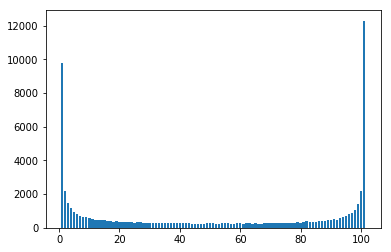

In [239]:
#Method 3: Rank Histogram
# !pip install rank-histogram
from ranky import rankz

obs = np.asarray(observation.to_array(), dtype=np.float32).squeeze();
obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

pred=np.asarray(preds.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 

mask=np.ones(obs_z500.shape) #useless
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() #Definitely bad. maybe because too few observations or beacuse of bad implementation

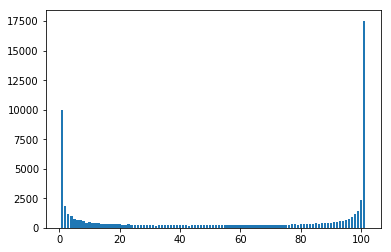

In [240]:
result = rankz(obs_t850, pred_t850, mask)
plt.bar(range(1,pred_t850.shape[0]+2), result[0])
plt.show() 

In [241]:
print(obs_t850.shape)
pred_t850.shape

(32, 32, 64)


(100, 32, 32, 64)

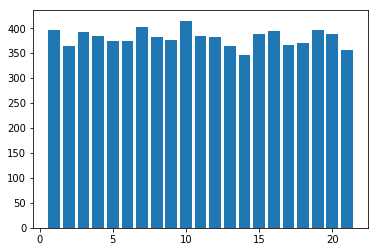

In [234]:
#sanity check: for a random sample
obs = np.random.randn(10, 40, 40)
ensemble = np.random.randn(20, 10, 40, 40)
mask = np.random.randint(0, 2, (10, 40, 40)) #masked where 0/false.
# feed into rankz function
result = rankz(obs, ensemble, mask)
# plot histogram
plt.bar(range(1,ensemble.shape[0]+2), result[0])
# view histogram
plt.show()

(32, 3)
(100, 32, 3)
(32, 3)


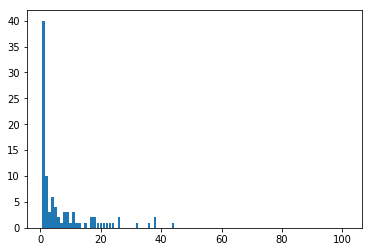

In [274]:
#testing for only few points
obs_small=obs_z500[:,15:18,0].squeeze()
pred_small=pred_z500[:,:,15:18,0]
mask=np.ones(obs_small.shape).squeeze()
print(obs_small.shape)
print(pred_small.shape)
print(mask.shape)

result = rankz(obs_small, pred_small, mask)
plt.bar(range(1,pred_small.shape[0]+2), result[0])
plt.show()

(32, 32, 64)
(10, 32, 32, 64)
(32, 32, 64)


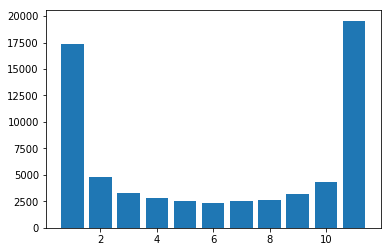

In [277]:
#testing for smaller number of bins (i.e. forecasts)
obs_small=obs_z500[:,:,:].squeeze()
pred_small=pred_z500[0:10,:,:,:]
mask=np.ones(obs_small.shape).squeeze()
print(obs_small.shape)
print(pred_small.shape)
print(mask.shape)

result = rankz(obs_small, pred_small, mask)
plt.bar(range(1,pred_small.shape[0]+2), result[0])
plt.show() #still bad. same shape.